In [128]:
import uproot

In [208]:
def track_pt(omega):
    a = 3 * 10**-4
    b = 2  # B-field in tesla, from clicRec_e4h_input

    return a * np.abs(b / omega)

In [129]:
fi = uproot.open("CLDConfig/CLDConfig/out_RECO_edm4hep.root")

In [130]:
ev = fi["events"]

In [177]:
mcp = ev["MCParticles"].arrays()

st1 = mcp["MCParticles.generatorStatus"]==1

mc_p4 = vector.awk(awkward.zip({
        "mass": mcp["MCParticles.mass"],
        "px": mcp["MCParticles.momentum.x"],
        "py": mcp["MCParticles.momentum.y"],
        "pz": mcp["MCParticles.momentum.z"],
    }))

pf = ev["PandoraPFOs"].arrays()
pf_p4 = vector.awk(awkward.zip({
        "mass": pf["PandoraPFOs.mass"],
        "px": pf["PandoraPFOs.momentum.x"],
        "py": pf["PandoraPFOs.momentum.y"],
        "pz": pf["PandoraPFOs.momentum.z"],
    }))

In [195]:
trackstates = ev["_SiTracks_trackStates"].arrays()

In [196]:
tracks = ev["SiTracks"].arrays()

In [213]:
omegas = trackstates[tracks["SiTracks.trackStates_begin"]]["_SiTracks_trackStates.omega"]
phis = trackstates[tracks["SiTracks.trackStates_begin"]]["_SiTracks_trackStates.phi"]
tanlambdas = trackstates[tracks["SiTracks.trackStates_begin"]]["_SiTracks_trackStates.tanLambda"]

In [215]:
track_pts = track_pt(omegas)
track_pxs = track_pts * np.cos(phis)
track_pys = track_pts * np.sin(phis)
track_pzs = track_pts * tanlambdas
track_ps = np.sqrt(track_pxs**2 + track_pys**2 + track_pzs**2)

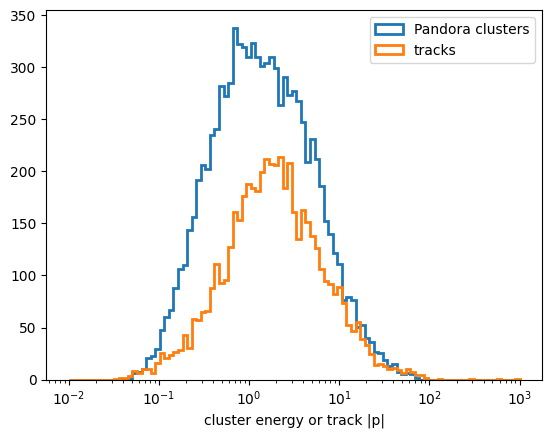

In [220]:
plt.hist(
    awkward.flatten(ev["PandoraClusters"].arrays()["PandoraClusters.energy"]),
    bins=np.logspace(-2,3,100), label="Pandora clusters",
    histtype="step", lw=2
)
plt.hist(
    awkward.flatten(track_ps),
    bins=np.logspace(-2,3,100), label="tracks",
    histtype="step", lw=2
)
plt.xscale("log")
plt.xlabel("cluster energy or track |p|")
plt.legend()

Text(0.5, 0, 'energy')

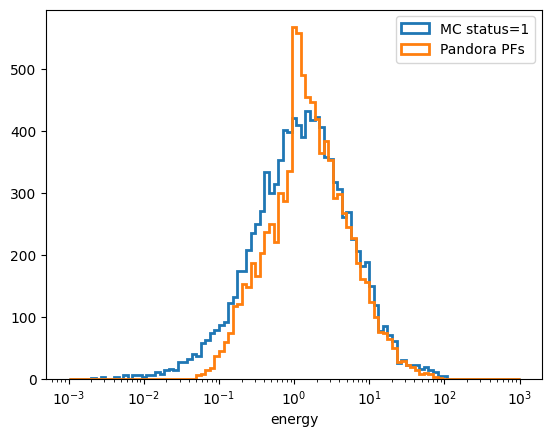

In [221]:
plt.hist(awkward.flatten(mc_p4.energy[st1]), bins=np.logspace(-3,3,100), histtype="step", lw=2, label="MC status=1");
plt.hist(awkward.flatten(pf_p4.energy), bins=np.logspace(-3,3,100), histtype="step", lw=2, label="Pandora PFs");
plt.xscale("log")
plt.legend(loc="best")
plt.xlabel("energy")

In [131]:
import uproot
import numpy as np
import pandas
import awkward

import plotly.graph_objects as go
import vector

import matplotlib.pyplot as plt

In [132]:
def hits_to_features(hit_data, iev, coll, feats):
    
    if "TrackerHit" in coll or "TrackerEndcapHits" in coll:
        new_feats = []
        for feat in feats:
            feat_to_get = feat
            if feat == "energy":
                feat_to_get = "eDep"
            new_feats.append((feat, feat_to_get))
    else:
        new_feats = [(f, f) for f in feats]
        
    feat_arr = {f1: hit_data[coll + "." + f2][iev] for f1, f2 in new_feats}

    sdcoll = "subdetector"
    feat_arr[sdcoll] = np.zeros(len(feat_arr["type"]), dtype=np.int32)
    if coll.startswith("ECAL"):
        feat_arr[sdcoll][:] = 0
    elif coll.startswith("HCAL"):
        feat_arr[sdcoll][:] = 1
    elif coll.startswith("MUON"):
        feat_arr[sdcoll][:] = 2
    else:
        feat_arr[sdcoll][:] = 3
    return awkward.Record(feat_arr)

In [133]:
pdg_dict = {
    22: "photon",  # photon    
    11: "electron",     # electron
    12: "neutrino",     # electron neutrino  
    13: "muon",     # muon
    14: "neutrino",     # muon neutrino 
    130: "n. hadron",      # strange meson (neutral hadron)
    2112: "n. hadron",    # n (neutral hadron)    
    211: "ch. hadron",   # pi+ (charged hadron)
    321: "ch. hadron",    # K+ (charged hadron)
    2212: "ch. hadron",   # proton (charged hadron) 
    -1: "",
}

In [137]:
# which event
iev = 1

In [138]:
collectionIDs = {k: v for k, v in
    zip(fi.get("podio_metadata").arrays("events___idTable/m_names")['events___idTable/m_names'][0],
    fi.get("podio_metadata").arrays("events___idTable/m_collectionIDs")["events___idTable/m_collectionIDs"][0])}
collectionIDs_reverse = {v: k for k, v in collectionIDs.items()}

hit_data = {
    "VXDTrackerHits": ev["VXDTrackerHits"].array(),
    "VXDEndcapTrackerHits": ev["VXDEndcapTrackerHits"].array(),
    "ITrackerHits": ev["ITrackerHits"].array(),
    "ITrackerEndcapHits": ev["ITrackerEndcapHits"].array(),
    "OTrackerHits": ev["OTrackerHits"].array(),
    "OTrackerEndcapHits": ev["OTrackerEndcapHits"].array(),
    "ECALBarrel": ev["ECALBarrel"].array(),
    "ECALEndcap": ev["ECALEndcap"].array(),
    "HCALBarrel": ev["HCALBarrel"].array(),
    "HCALEndcap": ev["HCALEndcap"].array(),
    "MUON": ev["MUON"].array(),
}
    
feats = ["position.x", "position.y", "position.z", "energy", "type"]

hit_feature_matrix = []
for col in sorted(hit_data.keys()):
    icol = collectionIDs[col]
    hit_features = hits_to_features(hit_data[col], iev, col, feats)
    hit_feature_matrix.append(hit_features)
    
hit_feature_matrix = awkward.Record({
    k: awkward.concatenate([hit_feature_matrix[i][k] for i in range(len(hit_feature_matrix))]) for k in hit_feature_matrix[0].fields})

##############

df = pandas.DataFrame()
df["px"] = hit_feature_matrix["position.x"].to_numpy()
df["py"] = hit_feature_matrix["position.y"].to_numpy()
df["pz"] = hit_feature_matrix["position.z"].to_numpy()
df["energy"] = 1000*hit_feature_matrix["energy"].to_numpy()
df["plotsize"] = 0.0
df["subdetector"] = hit_feature_matrix["subdetector"].to_numpy()

################

df.loc[df["subdetector"]==0, "plotsize"] = df.loc[df["subdetector"]==0, "energy"]/5
df.loc[df["subdetector"]==1, "plotsize"] = df.loc[df["subdetector"]==1, "energy"]/10
df.loc[df["subdetector"]==2, "plotsize"] = df.loc[df["subdetector"]==2, "energy"]*100
df.loc[df["subdetector"]==3, "plotsize"] = df.loc[df["subdetector"]==3, "energy"]*100

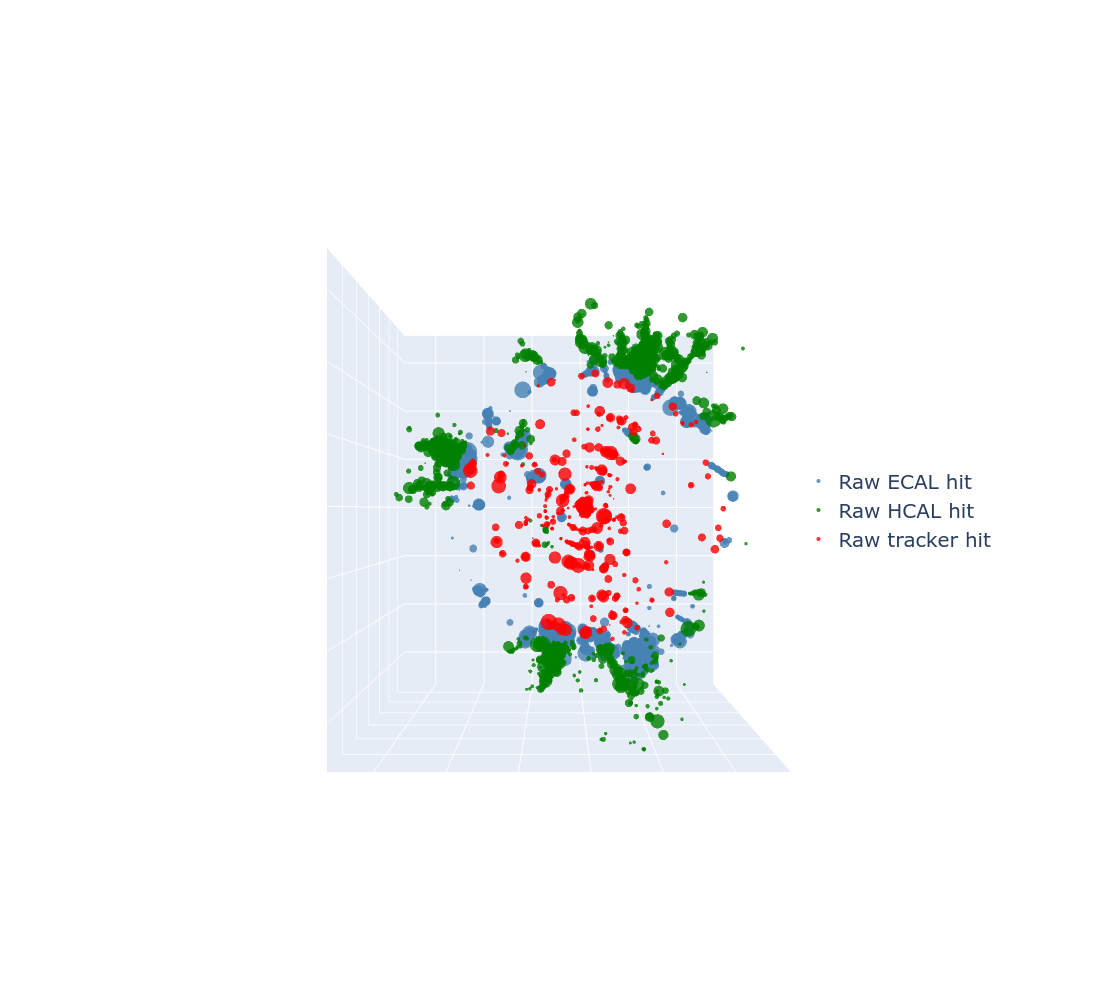

In [139]:
labels = {
    0: "Raw ECAL hit",
    1: "Raw HCAL hit",
    2: "Raw Muon chamber hit",
    3: "Raw tracker hit"
}

subdetector_color = {
    0: "steelblue",
    1: "green",
    2: "orange",
    3: "red"
}
    
    
### Create your 3D scatter plot of the raw hits

traces = []
for subdetector in df["subdetector"].unique():
    trace = go.Scatter3d(
        x=np.clip(df["px"][df["subdetector"]==subdetector], -8000, 8000),
        y=np.clip(df["py"][df["subdetector"]==subdetector], -8000, 8000),
        z=np.clip(df["pz"][df["subdetector"]==subdetector], -8000, 8000),
        mode='markers',
        marker=dict(
            size=np.clip(2+2*np.log(df["plotsize"]), 1, 15),
            color=subdetector_color[subdetector],
            colorscale='Viridis',
            opacity=0.8,
        ),
        name=labels[subdetector]
    )  

    traces.append(trace)


# Customize the axis names
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='', showticklabels=False),
        yaxis=dict(title='', showticklabels=False),
        zaxis=dict(title='', showticklabels=False),
        camera=dict(
            up=dict(x=1, y=0, z=0),  # Sets the orientation of the camera
            center=dict(x=0, y=0, z=0),  # Sets the center point of the plot
            eye=dict(x=0, y=0, z=2.5)  # Sets the position of the camera
        )
    ),
    legend=dict(x=0.75, y=0.5, font = dict(size = 20)),  # https://plotly.com/python/legend/
    showlegend=True,
    width=1000,
    height=1000
)

# Create the figure and display the plot
fig = go.Figure(data=traces, layout=layout)

fig.update_traces(marker_line_width=0, selector=dict(type='scatter3d'))   # for plotly to avoid plotting white spots when things overlap
fig.show()

In [141]:
# borrowed from here: https://github.com/farakiko/particleflow/blob/main/fcc/postprocessing.py

track_coll = "SiTracks"

track_feature_order = [
    "elemtype",
    "pt",
    "eta",
    "sin_phi",
    "cos_phi",
    "p",
    "chi2",
    "ndf",
    "dEdx",
    "dEdxError",
    "radiusOfInnermostHit",
    "tanLambda",
    "D0",
    "omega",
    "Z0",
    "time",
]

def track_pt(omega):
    a = 3 * 10**-4
    b = 2  # B-field in tesla, from clicRec_e4h_input

    return a * np.abs(b / omega)    


def track_to_features(prop_data, iev):
    track_arr = prop_data[track_coll][iev]
    feats_from_track = ["type", "chi2", "ndf", "dEdx", "dEdxError", "radiusOfInnermostHit"]
    ret = {feat: track_arr[track_coll + "." + feat] for feat in feats_from_track}
    n_tr = len(ret["type"])

    # get the index of the first track state
    trackstate_idx = prop_data[track_coll][track_coll + ".trackStates_begin"][iev]
    # get the properties of the track at the first track state (at the origin)
    for k in ["tanLambda", "D0", "phi", "omega", "Z0", "time"]:
        ret[k] = prop_data["_SiTracks_trackStates"]["_SiTracks_trackStates." + k][iev][trackstate_idx]

    ret["pt"] = track_pt(ret["omega"])
    ret["px"] = np.cos(ret["phi"]) * ret["pt"]
    ret["py"] = np.sin(ret["phi"]) * ret["pt"]
    ret["pz"] = ret["tanLambda"] * ret["pt"]
    
    ret["q"] = ret["omega"].to_numpy().copy()
    ret["q"][ret["q"]>0] = 1
    ret["q"][ret["q"]<0] = -1


    return ret